# Week 4 Tutorial (Solutions) - Latent Variable Models and Autoencoders

### Author: Rajit Rajpal

The goal of this tutorial will be to train various autoencoders (Plain, VAE, IW-VAE) on various datasets (Syntethic, MNIST). `# TODO` are for you to implement. Solutions will contain the completed code.

# 1. Setup
We begin by defining the core components. As shown in the slides, an autoencoder trains a neural network $f_{\theta, \phi}$ to predict $x$ from itself through a bottleneck $z$.

## 1.1 Imports

In [2]:
# Imports
# %pip install numpy matplotlib torch torchvision scipy pillow scikit-learn <- Uncomment and run this if you do not have the necessary packages.
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1.2 Architecture

We will have our autoencoder $f_{\theta, \phi}$ be a very simple MLP. Note that the autoencoder has two components: Encoder $E_{\phi}$ and Decoder $D_{\theta}$. In order to keep the rest of the code self-contained, we include VAE within the architecture which can be enabled by setting `is_vae=True`.

In [3]:
class GenerativeModel(torch.nn.Module):
    def __init__(self, input_dim, latent_dim, is_vae=False):
        super().__init__()
        self.is_vae = is_vae
        # Encoder: compresses high-dim data
        self.enc = torch.nn.Sequential(
            torch.nn.Linear(input_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, latent_dim if not is_vae else latent_dim * 2)
        )
        # Decoder: reconstructs data from latents
        self.dec = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, input_dim)
        )

    def encode(self, x):
        out = self.enc(x)
        if not self.is_vae:
            return out
        mu, logvar = torch.chunk(out, 2, dim=-1)
        return mu, logvar

    def decode(self, z):
        return self.dec(z)

# 2 Loss Functions

## 2.1 Autoencoder

It is quite simple to train an autoencoder. The simplest thing one can do is minimize the objective: $$ L_{\text{AE}}((\theta, \phi); x) = \|x - D_{\theta}(E_{\phi}(x))\|^2.$$ The norm can be L1 (Mean Absolute Error) or L2 (Mean Squared Error). Try them both, see what happens! We are effectively trying to find a compressed "bottleneck" representation $z \in \R^{d_{\text{latent}}}$ of $x \in \R^{d_{\text{data}}}$.

In [12]:
def loss_ae(x, x_recon, loss_type='mse'):
    """
    Computes the reconstruction loss for a standard Autoencoder.
    """
    if loss_type == 'mse':
        # Default: Squared Error
        return torch.sum((x - x_recon)**2)
    elif loss_type == 'mae':
        # Absolute Error
        return torch.sum(torch.abs(x - x_recon))
    else:
        raise ValueError(f"Unknown loss_type: {loss_type}")

## 2.2 Variational Autoencoder (VAE)

A standard AE does not define a known distribution for $z$, making it impossible to sample new data! The VAE solves this by forcing the latent space to follow a prior $p(z)$, typically a Gaussian $N(0,I)$. We will refer to the probability distribution of the Encoder as $q_{\phi}(z|x)$ and Decoder as $p_{\theta}(x|z)$.

Following Lecture 3 Slide 12, it was shown that:
$$
L_{\text{VAE}}((\theta, \phi); x)
=
\underbrace{
\mathbb{E}_{z \sim q_{\phi}(z|x)}\!\left[\|x - D_{\theta}(z)\|^2\right]
}_{\text{reconstruction loss}}
+
\underbrace{
\mathrm{KL}\!\left(q_{\phi}(z|x)\,\|\,p(z)\right)
}_{\text{prior matching loss}}.
$$

The expectation is obviously approximated using Monte-Carlo.

If $q_{\phi}(z \mid x) = \mathcal{N}(\mu, \sigma^2)$, the KL term has the closed-form solution:

$$
\mathrm{KL}\bigl(q_{\phi}(z \mid x)\,\|\,p(z)\bigr)
=
\frac{1}{2}
\sum_{j=1}^{d_{\text{latent}}}
\left(
\sigma_j^2
+
\mu_j^2
-
1
-
\log \sigma_j^2
\right)
$$



In [13]:
def loss_vae(x, x_recon, mu, logvar):
    """
    Computes the VAE objective (Negative ELBO).
    Based on Lecture 3, Slide 12.
    """
    # 1. Reconstruction Loss (Standard MSE)
    recon_loss = torch.sum((x - x_recon)**2)
    
    # 2. Prior-matching Loss (KL Divergence for Gaussians)
    # This forces the latent space to follow N(0, I)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    
    return recon_loss + kl_loss

### 2.2.1 Reparameterization Trick

To allow backpropagation through stochastic nodes, we use the reparameterization: $$ z = \mu + \sigma \odot \epsilon $$ where $\epsilon \sim \mathcal{N}(0, I)$.

In [14]:
def reparameterize(mu, logvar):
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + eps * std

## 2.3 Importance-Weighted VAE (IW-VAE)

We will now implement the **Importance-Weighted Autoencoder (IWAE)** loss. This model addresses a key limitation of the standard VAE: the *looseness* of the Evidence Lower Bound (ELBO).

In a standard VAE, we maximize the ELBO for a single data point $x$:

$$
\log p_{\theta}(x)
\ge
\mathbb{E}_{z \sim q_{\phi}(z \mid x)}
\left[
\log
\frac{p_{\theta}(x, z)}{q_{\phi}(z \mid x)}
\right]
$$

The IWAE improves this by using $K$ samples from the approximate posterior
to create a tighter lower bound:

$$
\log p_{\theta}(x)
\ge
\mathbb{E}_{z_1, \ldots, z_K \sim q_{\phi}(z \mid x)}
\left[
\log
\frac{1}{K}
\sum_{k=1}^{K}
\frac{p_{\theta}(x, z_k)}{q_{\phi}(z_k \mid x)}
\right]
$$

### Why use IWAE?

- **Tighter Bound:** As $K \to \infty$, the IWAE bound approaches the true
  log-likelihood $\log p_{\theta}(x)$. It is clear to observe that when K=1, IWAE corresponds to VAE.

- **Expressive Posteriors:** IWAE effectively increases the expressiveness of
  the variational posterior without changing the model architecture.

- **Better Likelihood Estimation:** It provides a more accurate estimate for
  evaluating new data.


Please refer to this very well-written blog post for more info on IW-VAE (https://borea17.github.io/paper_summaries/iwae/).

In [15]:
def loss_iwae(x, mu, logvar, decoder, K=5):
    """
    Computes the IWAE objective as a tighter lower bound on log p(x).
    """
    batch_size = x.size(0)
    log_weights = []

    # Sample K times for each input in the batch 
    for _ in range(K):
        # Sample z from the approximate posterior using reparameterize()
        z_k = reparameterize(mu, logvar) # [batch_size, latent_dim]
        x_recon_k = decoder(z_k)
        
        # log p(x|z) - Log-likelihood of the data given the sample
        # Assuming Gaussian reconstruction with fixed variance
        log_p_x_z = -torch.sum((x - x_recon_k)**2, dim=1)
        
        # log p(z) - Log-prior probability of the sample
        log_p_z = -0.5 * torch.sum(z_k**2, dim=1)
        
        # log q(z|x) - Log-probability of the sample under the approximate posterior
        log_q_z_x = -0.5 * torch.sum(logvar + (z_k - mu)**2 / torch.exp(logvar), dim=1)
        
        # Compute the importance weight for this sample 
        # log( p(x,z) / q(z|x) ) = log p(x|z) + log p(z) - log q(z|x)
        log_weights.append(log_p_x_z + log_p_z - log_q_z_x)
        
    # Stack samples to shape [K, batch_size]
    log_w_matrix = torch.stack(log_weights)
    
    # Apply the Log-Sum-Exp trick to average over K samples 
    # We negate because we minimize the negative log-likelihood estimate
    iwae_loss = -(torch.logsumexp(log_w_matrix, dim=0) - torch.log(torch.tensor(K, dtype=torch.float))).mean()
    return iwae_loss

## Putting them together...

In [16]:
def compute_loss(model_type, x, x_recon, mu=None, logvar=None, decoder=None, K=5, loss_type='mse'):
    """
    Consolidated loss function for AE, VAE, and IWAE.
    """
    if model_type == "AE":
        return loss_ae(x, x_recon, loss_type=loss_type)
    
    elif model_type == "VAE":
        if mu is None or logvar is None:
            raise ValueError("VAE requires mu and logvar for the KL term.")
        return loss_vae(x, x_recon, mu, logvar)
    
    elif model_type == "IWAE":
        if mu is None or logvar is None or decoder is None:
            raise ValueError("IWAE requires mu, logvar, and the decoder network.")
        return loss_iwae(x, mu, logvar, decoder, K=K)    
    
    else:
        raise ValueError(f"Unknown model_type: {model_type}")

# 3 Data Loading: Synthetic High-Dimensional GMM

We will generate a synthetic high-dimensional dataset where the data lies on a manifold that can be compressed. A classic choice for this is a Gaussian Mixture Model (GMM) in high dimensions, which provides distinct "classes" for visualization. We will generate data in $\R^{100}$ clustered around 5 centers. Although the data is 100D, the underlying structure is simple enough for a 2D or 3D latent space to capture.

In [17]:
def load_synthetic_data(n_samples=5000, input_dim=100, n_classes=5):
    """
    Generates high-dimensional synthetic data with distinct clusters.
    """
    # Create clusters in high-dimensional space
    data, labels = make_blobs(
        n_samples=n_samples, 
        n_features=input_dim, 
        centers=n_classes, 
        cluster_std=1.5, 
        random_state=42
    )
    
    # Normalize data
    data = (data - data.mean()) / data.std()
    
    # Convert to PyTorch tensors
    x_train = torch.FloatTensor(data)
    y_train = torch.LongTensor(labels)
    
    dataset = TensorDataset(x_train, y_train)
    return DataLoader(dataset, batch_size=64, shuffle=True), input_dim

# Initialize data
train_loader, input_dim = load_synthetic_data()
print(f"Loaded {len(train_loader.dataset)} samples with input dimension {input_dim}")

Loaded 5000 samples with input dimension 100


# 4 Training

In [18]:
def train_model(model, train_loader, model_type='VAE', epochs=20, lr=1e-3, K=5):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    model.train()
    
    for epoch in range(epochs + 1):
        total_loss = 0
        for x, _ in train_loader:
            optimizer.zero_grad()
            
            if model_type == 'AE':
                z = model.encode(x)
                x_recon = model.decode(z)
                loss = compute_loss('AE', x, x_recon)
            
            elif model_type == 'VAE':
                mu, logvar = model.encode(x)
                z = reparameterize(mu, logvar)
                x_recon = model.decode(z)
                loss = compute_loss('VAE', x, x_recon, mu=mu, logvar=logvar)
                
            elif model_type == 'IWAE':
                # IWAE requires mu and logvar to sample internally within loss_iwae
                mu, logvar = model.encode(x)
                # We pass the decoder because IWAE needs to reconstruct K times
                loss = compute_loss('IWAE', x, None, mu=mu, logvar=logvar, 
                                    decoder=model.dec, K=K)
                
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
        if epoch % 5 == 0 or epoch == 0:
            print(f"[{model_type}] Epoch {epoch}/{epochs}, Average Loss: {total_loss/len(train_loader):.4f}")

# Setup experiment
latent_dim = 2 

# 1. Train Autoencoder
print("--- Training Autoencoder ---")
ae_model = GenerativeModel(input_dim, latent_dim, is_vae=False)
train_model(ae_model, train_loader, model_type='AE', epochs=20)

print("\n" + "="*30 + "\n")

# 2. Train Variational Autoencoder
print("--- Training Variational Autoencoder ---")
vae_model = GenerativeModel(input_dim, latent_dim, is_vae=True)
train_model(vae_model, train_loader, model_type='VAE', epochs=20)

print("\n" + "="*30 + "\n")

# 3. Train Importance-Weighted Autoencoder
print("--- Training Importance-Weighted Autoencoder ---")
# IWAE uses the same stochastic encoder architecture as VAE
iwae_model = GenerativeModel(input_dim, latent_dim, is_vae=True)
train_model(iwae_model, train_loader, model_type='IWAE', epochs=20, K=5)

--- Training Autoencoder ---
[AE] Epoch 0/20, Average Loss: 3572.5801
[AE] Epoch 5/20, Average Loss: 380.5089
[AE] Epoch 10/20, Average Loss: 377.4738
[AE] Epoch 15/20, Average Loss: 376.4894
[AE] Epoch 20/20, Average Loss: 376.0304


--- Training Variational Autoencoder ---
[VAE] Epoch 0/20, Average Loss: 3839.3547
[VAE] Epoch 5/20, Average Loss: 396.5537
[VAE] Epoch 10/20, Average Loss: 391.1748
[VAE] Epoch 15/20, Average Loss: 388.5466
[VAE] Epoch 20/20, Average Loss: 386.4320


--- Training Importance-Weighted Autoencoder ---
[IWAE] Epoch 0/20, Average Loss: 50.9627
[IWAE] Epoch 5/20, Average Loss: 11.8211
[IWAE] Epoch 10/20, Average Loss: 11.4202
[IWAE] Epoch 15/20, Average Loss: 11.2542
[IWAE] Epoch 20/20, Average Loss: 11.1134


# 5 Visualization

Observe the difference in scales. VAE has very strong KL regularization so it is very close to 0 (fitting to the prior). There are techniques to alleviate this like KL annealing but we will not cover that (for now..).

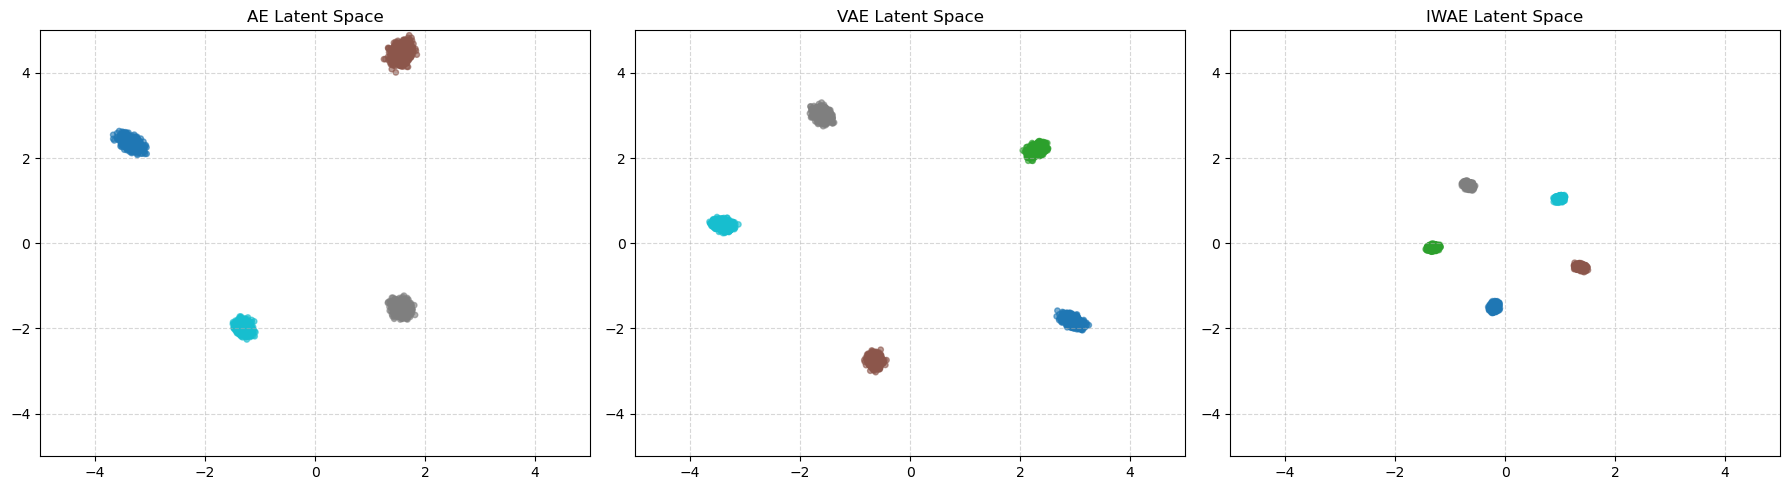

In [20]:
def visualize_three_comparison(ae_model, vae_model, iwae_model, train_loader):
    models = [('AE', ae_model), ('VAE', vae_model), ('IWAE', iwae_model)]
    plt.figure(figsize=(18, 5))
    
    for i, (model_type, model) in enumerate(models):
        model.eval()
        latents, labels = [], []
        with torch.no_grad():
            for x, y in train_loader:
                out = model.encode(x)
                z = out[0] if isinstance(out, tuple) else out # Use mu for VAE/IWAE
                latents.append(z)
                labels.append(y)

        latents = torch.cat(latents, dim=0).numpy()
        labels = torch.cat(labels, dim=0).numpy()

        plt.subplot(1, 3, i + 1)
        scatter = plt.scatter(latents[:, 0], latents[:, 1], c=labels, cmap='tab10', alpha=0.6, s=15)
        plt.title(f'{model_type} Latent Space')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.xlim(-5, 5); plt.ylim(-5, 5)
            
    plt.tight_layout()
    plt.show()

visualize_three_comparison(ae_model, vae_model, iwae_model, train_loader)

# MNIST

Let us repeat that but with images. We will use the famed (but simple) MNIST dataset. Running the code below, it should load MNIST data and save into the same folder under "data/".

Loaded MNIST: 60000 images, Input Dimension: 784


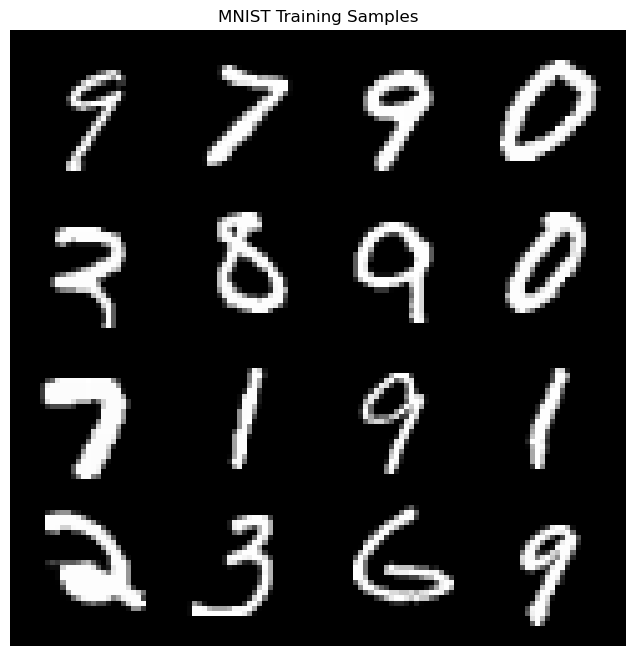

In [21]:
def load_mnist_data(batch_size=128):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(lambda x: torch.flatten(x)) # Flatten 28x28 to 784
    ])
    
    train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    return train_loader, 784

# Initialize MNIST
mnist_loader, mnist_dim = load_mnist_data()
print(f"Loaded MNIST: {len(mnist_loader.dataset)} images, Input Dimension: {mnist_dim}")

def visualize_mnist_samples(loader, n_samples=16):
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    # Reshape flattened 784 back to (1, 28, 28) for visualization
    images = images.view(-1, 1, 28, 28)
    
    # Create a grid
    grid = torchvision.utils.make_grid(images[:n_samples], nrow=4)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(grid.permute(1, 2, 0).numpy(), cmap='gray')
    plt.axis('off')
    plt.title("MNIST Training Samples")
    plt.show()

visualize_mnist_samples(mnist_loader)

In [22]:
def visualize_all_reconstructions(models_list, loader, n_samples=10):
    """
    Visualizes original images followed by reconstructions from each model side-by-side.
    """
    for _, model in models_list:
        model.eval()
        
    # Get a batch of samples
    data_iter = iter(loader)
    images, _ = next(data_iter)
    images = images[:n_samples]
    
    # Create a grid for (Original + n_models) rows
    plt.figure(figsize=(n_samples * 1.5, (len(models_list) + 1) * 1.5))
    
    # 1. Plot Original Inputs
    for i in range(n_samples):
        plt.subplot(len(models_list) + 1, n_samples, i + 1)
        # Reshape flattened 784 back to 28x28
        plt.imshow(images[i].view(28, 28).cpu().numpy(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title("Original Data", loc='left', fontsize=12, fontweight='bold')
            
    # 2. Plot Reconstructions for each model row by row
    for m_idx, (name, model) in enumerate(models_list):
        with torch.no_grad():
            # Pass through encoder
            out = model.encode(images)
            # Use mu for probabilistic models (VAE/IWAE) or the direct z for AE
            z = out[0] if isinstance(out, tuple) else out 
            
            # Decode the latent back to image space
            recons = model.decode(z)
            recons = recons.view(-1, 28, 28).cpu().numpy()
            
            for i in range(n_samples):
                plt.subplot(len(models_list) + 1, n_samples, (m_idx + 1) * n_samples + i + 1)
                plt.imshow(recons[i], cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title(f"{name} Recon", loc='left', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.show()

## Train

This will take about 4 minutes total.

In [23]:
latent_dim = 2

# 1. Train MNIST Autoencoder (AE)
print("--- Training MNIST Autoencoder ---")
ae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=False)
train_model(ae_mnist, mnist_loader, model_type='AE', epochs=15)

print("\n" + "="*30 + "\n")

# 2. Train MNIST Variational Autoencoder (VAE)
print("--- Training MNIST Variational Autoencoder ---")
vae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=True)
train_model(vae_mnist, mnist_loader, model_type='VAE', epochs=15)

print("\n" + "="*30 + "\n")

# 3. Train MNIST Importance-Weighted Autoencoder (IWAE)
print("--- Training MNIST IWAE ---")
iwae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=True)
train_model(iwae_mnist, mnist_loader, model_type='IWAE', epochs=15, K=5)

--- Training MNIST Autoencoder ---
[AE] Epoch 0/15, Average Loss: 5923.6516
[AE] Epoch 5/15, Average Loss: 4598.4129
[AE] Epoch 10/15, Average Loss: 4406.8426
[AE] Epoch 15/15, Average Loss: 4304.4190


--- Training MNIST Variational Autoencoder ---
[VAE] Epoch 0/15, Average Loss: 6102.6586
[VAE] Epoch 5/15, Average Loss: 4707.4903
[VAE] Epoch 10/15, Average Loss: 4536.6300
[VAE] Epoch 15/15, Average Loss: 4441.3921


--- Training MNIST IWAE ---
[IWAE] Epoch 0/15, Average Loss: 48.2873
[IWAE] Epoch 5/15, Average Loss: 39.9763
[IWAE] Epoch 10/15, Average Loss: 39.1221
[IWAE] Epoch 15/15, Average Loss: 38.5907


## Visualize in 2D

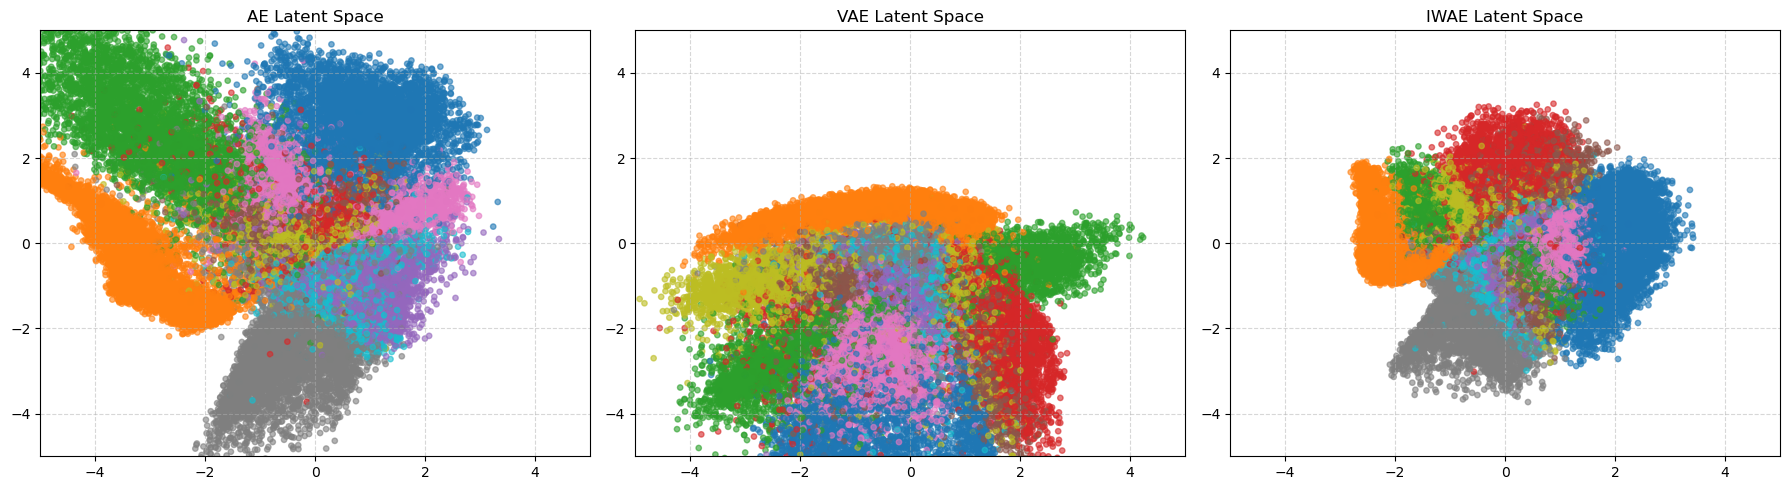

In [24]:
visualize_three_comparison(ae_mnist, vae_mnist, iwae_mnist, mnist_loader)

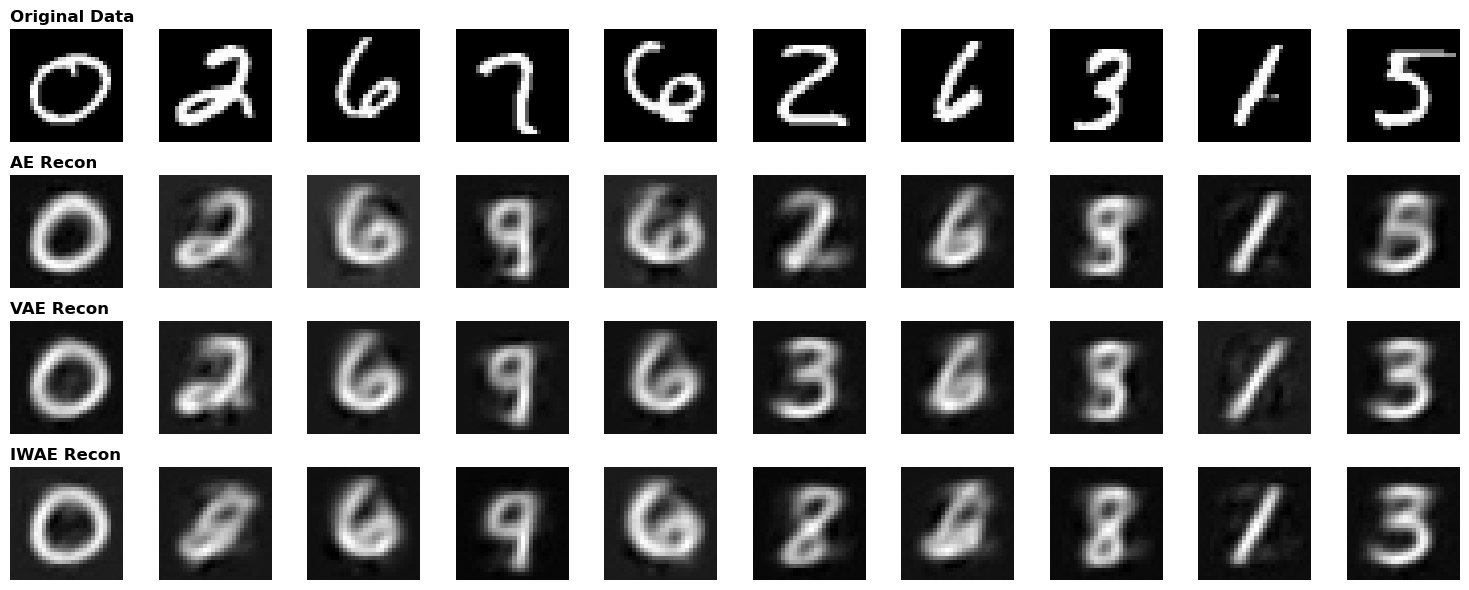

In [25]:
models_to_compare = [
    ('AE', ae_mnist),
    ('VAE', vae_mnist),
    ('IWAE', iwae_mnist)
]

# Run visualization on the MNIST loader
visualize_all_reconstructions(models_to_compare, mnist_loader)

## Increase latent dim

In [26]:
latent_dim = 3

# 1. Train MNIST Autoencoder (AE)
print("--- Training MNIST Autoencoder ---")
ae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=False)
train_model(ae_mnist, mnist_loader, model_type='AE', epochs=15)

print("\n" + "="*30 + "\n")

# 2. Train MNIST Variational Autoencoder (VAE)
print("--- Training MNIST Variational Autoencoder ---")
vae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=True)
train_model(vae_mnist, mnist_loader, model_type='VAE', epochs=15)

print("\n" + "="*30 + "\n")

# 3. Train MNIST Importance-Weighted Autoencoder (IWAE)
print("--- Training MNIST IWAE ---")
iwae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=True)
train_model(iwae_mnist, mnist_loader, model_type='IWAE', epochs=15, K=5)

--- Training MNIST Autoencoder ---
[AE] Epoch 0/15, Average Loss: 5557.9869
[AE] Epoch 5/15, Average Loss: 4014.0766
[AE] Epoch 10/15, Average Loss: 3875.0240
[AE] Epoch 15/15, Average Loss: 3801.7838


--- Training MNIST Variational Autoencoder ---
[VAE] Epoch 0/15, Average Loss: 5845.9413
[VAE] Epoch 5/15, Average Loss: 4109.6316
[VAE] Epoch 10/15, Average Loss: 3952.6935
[VAE] Epoch 15/15, Average Loss: 3871.1048


--- Training MNIST IWAE ---
[IWAE] Epoch 0/15, Average Loss: 46.8540
[IWAE] Epoch 5/15, Average Loss: 37.8225
[IWAE] Epoch 10/15, Average Loss: 36.6163
[IWAE] Epoch 15/15, Average Loss: 36.0920


## Visualize in 3D

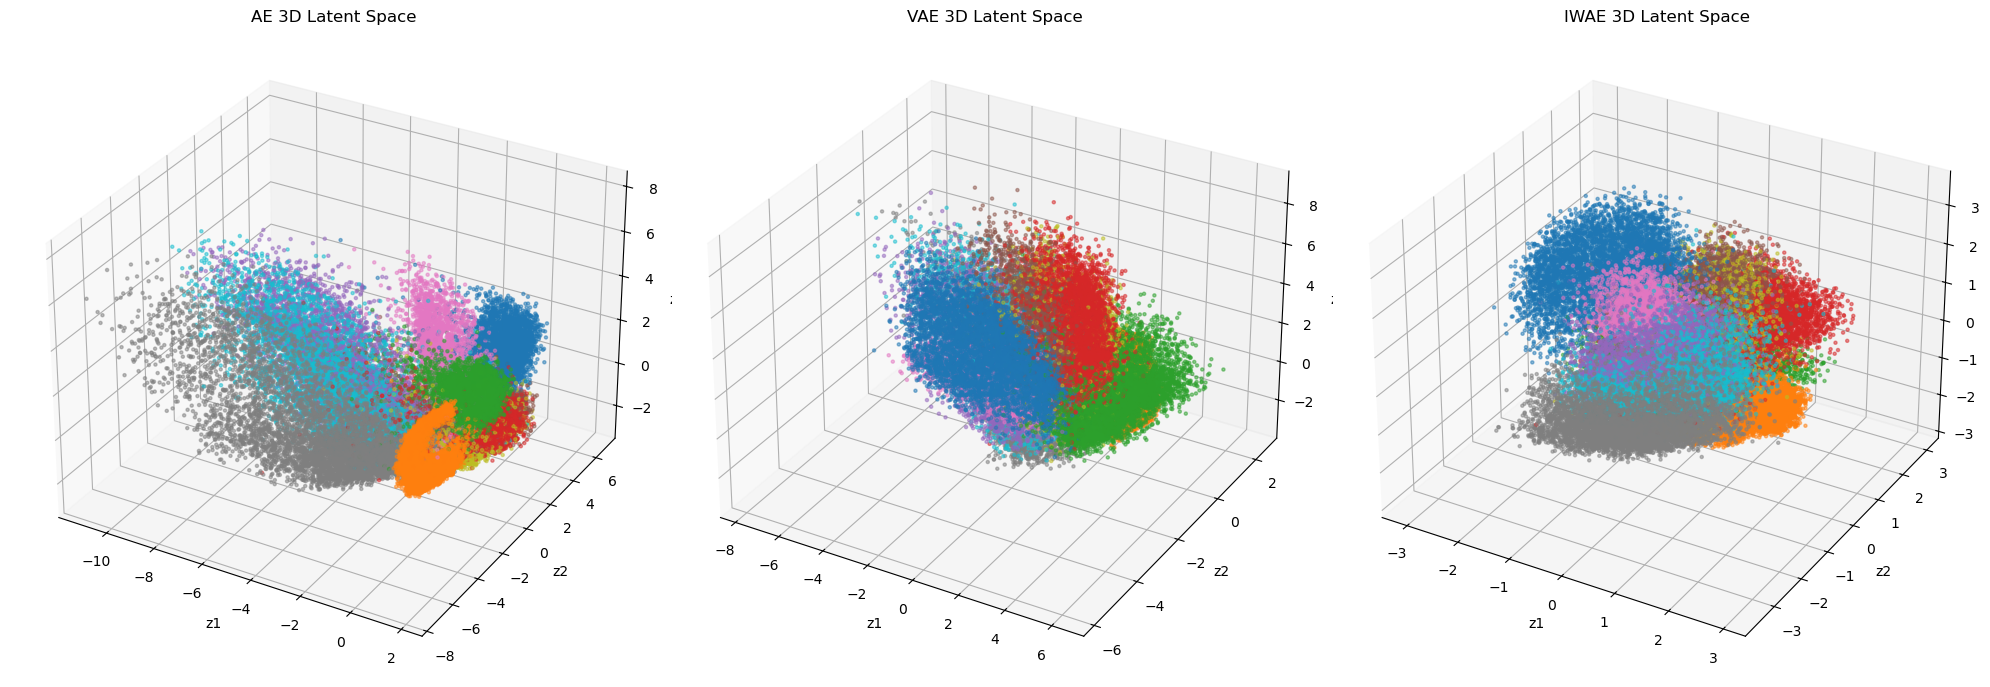

In [27]:
def visualize_three_comparison_3d(ae_model, vae_model, iwae_model, train_loader):
    """
    Plots the 3D latent space of AE, VAE, and IWAE side-by-side.
    """
    models = [('AE', ae_model), ('VAE', vae_model), ('IWAE', iwae_model)]
    fig = plt.figure(figsize=(20, 7))
    
    for i, (model_type, model) in enumerate(models):
        model.eval()
        latents, labels = [], []
        
        with torch.no_grad():
            for x, y in train_loader:
                out = model.encode(x)
                # Use mu for VAE/IWAE, or the direct bottleneck for AE
                z = out[0] if isinstance(out, tuple) else out
                latents.append(z)
                labels.append(y)

        latents = torch.cat(latents, dim=0).numpy()
        labels = torch.cat(labels, dim=0).numpy()

        ax = fig.add_subplot(1, 3, i + 1, projection='3d')
        scatter = ax.scatter(latents[:, 0], latents[:, 1], latents[:, 2], 
                             c=labels, cmap='tab10', alpha=0.5, s=5)
        
        ax.set_title(f'{model_type} 3D Latent Space')
        ax.set_xlabel('z1')
        ax.set_ylabel('z2')
        ax.set_zlabel('z3')
        
        # Consistent scaling for probabilistic models to see the Gaussian prior match
        #if model_type != 'AE':
            #ax.set_xlim(-4, 4); ax.set_ylim(-4, 4); ax.set_zlim(-4, 4)
            
    plt.tight_layout()
    plt.show()

visualize_three_comparison_3d(ae_mnist, vae_mnist, iwae_mnist, mnist_loader)

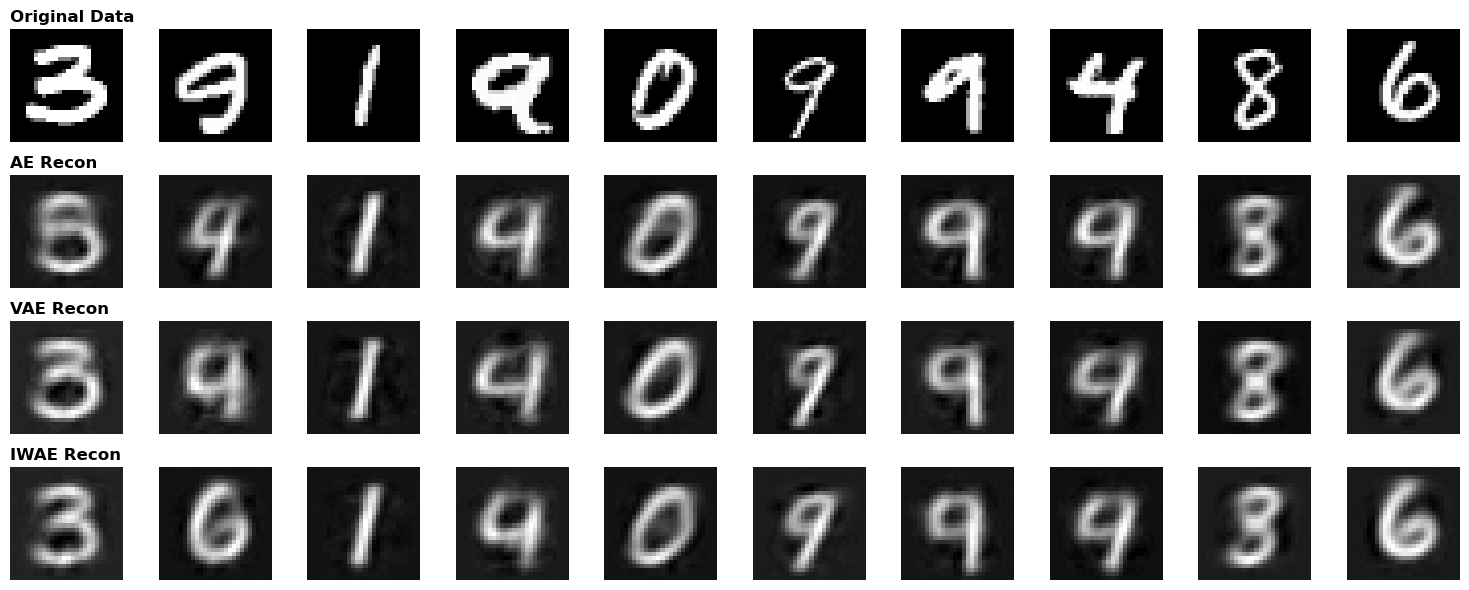

In [ ]:
models_to_compare = [
    ('AE', ae_mnist),
    ('VAE', vae_mnist),
    ('IWAE', iwae_mnist)
]

# Run visualization on the MNIST loader
visualize_all_reconstructions(models_to_compare, mnist_loader)

All the reconstructions seem to be quite blurry. There are many techniques to alleviate this issue and get sharper reconstructions. There is also a separate model called VQ-VAE that fixes the prior as a categorical distribution over a codebook. It manages to achieve sharp reconstructions. You might also notice that increasing the latent dimension will make the reconstructions (and losses) a lot better because there is less to compress. You can also experiment switching the reconstruction loss from squared error to absolute error (this may lead to sharper results!).

### Let us now try to increase latent dim to something more reasonable like 28. We won't be able to visualize the latent space as easily, but perhaps the reconstructions will look better.

--- Training MNIST Autoencoder ---
[AE] Epoch 0/15, Average Loss: 3758.3612
[AE] Epoch 5/15, Average Loss: 1880.0993
[AE] Epoch 10/15, Average Loss: 1861.8394
[AE] Epoch 15/15, Average Loss: 1818.4345


--- Training MNIST Variational Autoencoder ---
[VAE] Epoch 0/15, Average Loss: 4723.2662
[VAE] Epoch 5/15, Average Loss: 1921.3533
[VAE] Epoch 10/15, Average Loss: 1719.0430
[VAE] Epoch 15/15, Average Loss: 1639.7589


--- Training MNIST IWAE ---
[IWAE] Epoch 0/15, Average Loss: 47.8600
[IWAE] Epoch 5/15, Average Loss: 34.3420
[IWAE] Epoch 10/15, Average Loss: 33.6317
[IWAE] Epoch 15/15, Average Loss: 33.2705


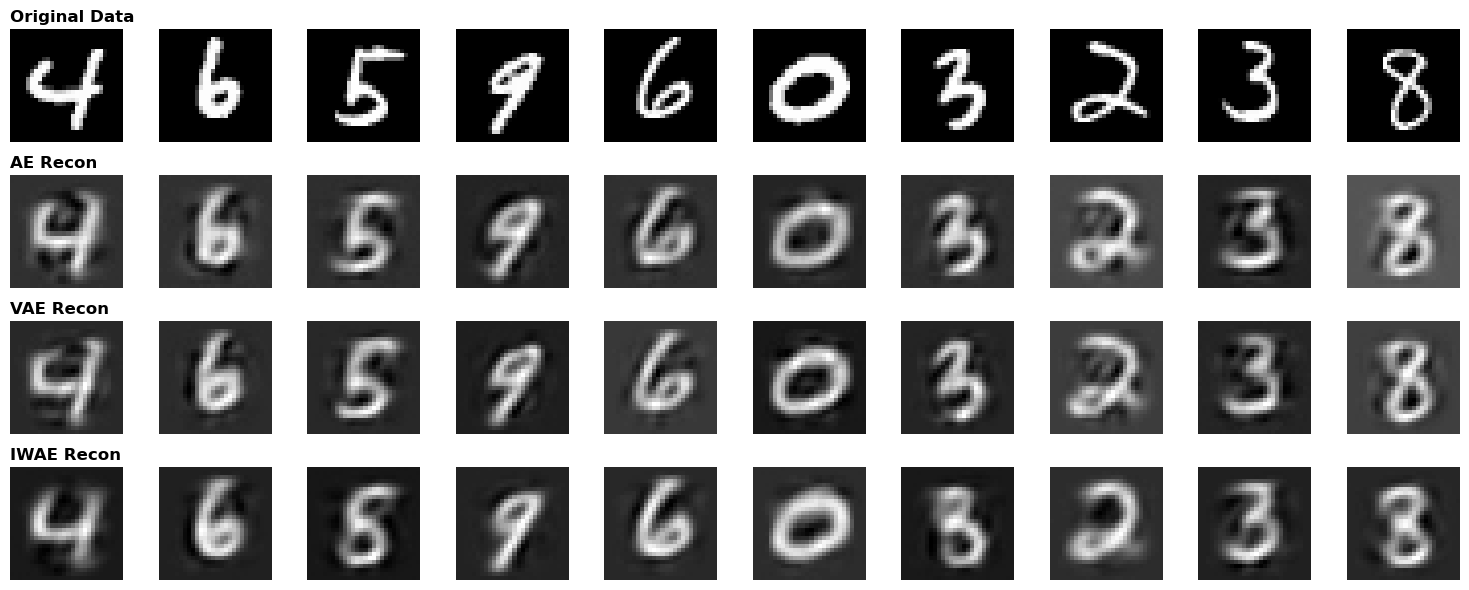

In [31]:
latent_dim = 28

# 1. Train MNIST Autoencoder (AE)
print("--- Training MNIST Autoencoder ---")
ae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=False)
train_model(ae_mnist, mnist_loader, model_type='AE', epochs=15)

print("\n" + "="*30 + "\n")

# 2. Train MNIST Variational Autoencoder (VAE)
print("--- Training MNIST Variational Autoencoder ---")
vae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=True)
train_model(vae_mnist, mnist_loader, model_type='VAE', epochs=15)

print("\n" + "="*30 + "\n")

# 3. Train MNIST Importance-Weighted Autoencoder (IWAE)
print("--- Training MNIST IWAE ---")
iwae_mnist = GenerativeModel(mnist_dim, latent_dim, is_vae=True)
train_model(iwae_mnist, mnist_loader, model_type='IWAE', epochs=15, K=5)

models_to_compare = [
    ('AE', ae_mnist),
    ('VAE', vae_mnist),
    ('IWAE', iwae_mnist)
]

# Run visualization on the MNIST loader
visualize_all_reconstructions(models_to_compare, mnist_loader)

# 6 Interpolation

Reconstruction is cool, but we would naturally expect an Autoencoder to do the best because it is not regularized by a prior. So why include a prior? Well, one nice reason is to learn a smooth, continuous latent space rather than just memorizing the data. You may have observed this feature in the latent spaces visualized in previous exercises. Let us now experiment with interpolation using our VAE.

To interpolate between two images (A and B), you don't average the images themselves; you average their latent representations. Encode two images $x_A$ and $x_B$ into $z_A$ and $z_B$. How about the famous numbers from the meme "6" "7"?

![Diagram](6-6-7.png)


Create a series of latent vectors $$ z_{\alpha} = (1-\alpha)z_A + \alpha z_B, $$

where $\alpha \in [0,1]$.


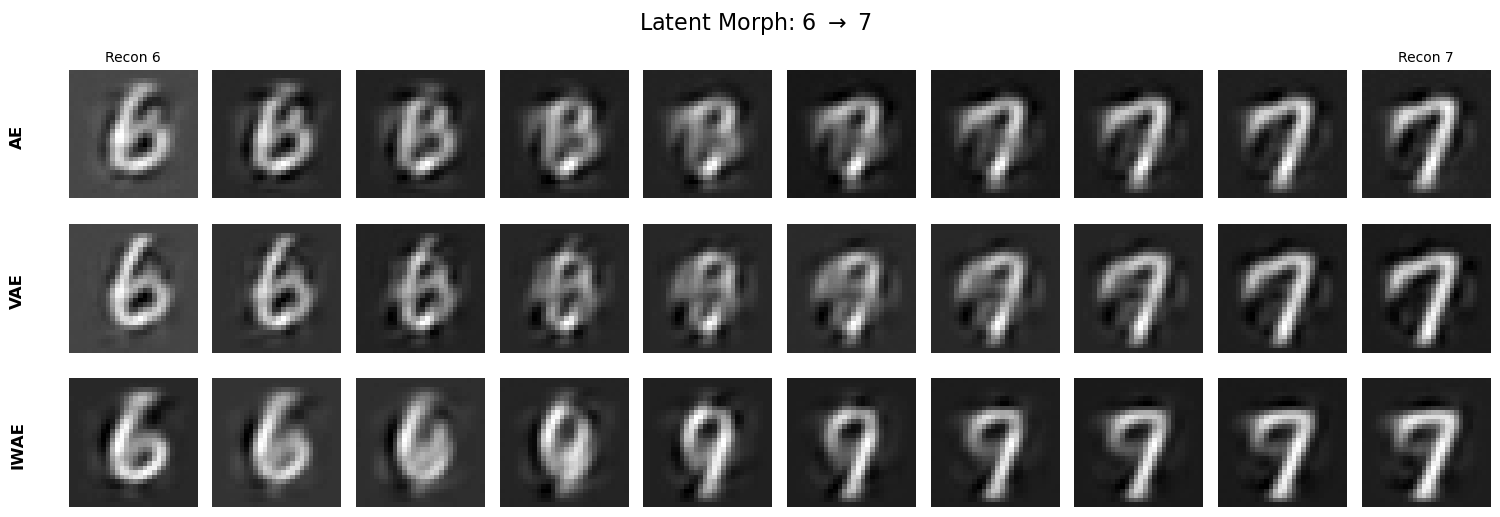

In [34]:
def get_specific_digits(loader, digit_a, digit_b):
    """Helper to grab a single instance of two specific digits."""
    img_a, img_b = None, None
    for images, labels in loader:
        for i in range(len(labels)):
            if labels[i] == digit_a and img_a is None:
                img_a = images[i]
            if labels[i] == digit_b and img_b is None:
                img_b = images[i]
        if img_a is not None and img_b is not None:
            break
    return img_a, img_b

def visualize_reconstructed_interpolation(models_list, loader, digit_a=6, digit_b=7, steps=10):
    # 1. Grab one '6' and one '7' from the loader
    img_a, img_b = get_specific_digits(loader, digit_a, digit_b)
    
    # Prepare the plot: Rows = Models, Cols = Steps
    fig, axes = plt.subplots(len(models_list), steps, figsize=(steps * 1.5, len(models_list) * 1.8))
    
    for m_idx, (name, model) in enumerate(models_list):
        model.eval()
        with torch.no_grad():
            # 2. Encode to latent space
            out_a = model.encode(img_a.unsqueeze(0))
            out_b = model.encode(img_b.unsqueeze(0))
            
            # Extract mean (z) for interpolation
            z_a = out_a[0] if isinstance(out_a, tuple) else out_a
            z_b = out_b[0] if isinstance(out_b, tuple) else out_b
            
            # 3. Linearly space out the latent vectors
            # alpha=0 is 100% digit A, alpha=1 is 100% digit B
            alphas = torch.linspace(0, 1, steps).to(z_a.device)
            
            for i, alpha in enumerate(alphas):
                # Compute interpolated latent point
                z_interp = (1 - alpha) * z_a + alpha * z_b
                
                # 4. Decode point back to image
                recon = model.decode(z_interp).view(28, 28).cpu().numpy()
                
                # 5. Plotting logic
                ax = axes[m_idx, i]
                ax.imshow(recon, cmap='gray')
                ax.axis('off')
                
                # Labels for clarity
                if i == 0 and m_idx == 0:
                    ax.set_title(f"Recon {digit_a}", fontsize=10)
                if i == steps - 1 and m_idx == 0:
                    ax.set_title(f"Recon {digit_b}", fontsize=10)
                if i == 0:
                    axes[m_idx, 0].text(-10, 14, name, rotation=90, 
                                        va='center', ha='right', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)
    fig.suptitle(f"Latent Morph: {digit_a} $\\rightarrow$ {digit_b}", fontsize=16)
    plt.show()

# Execute with your trained models
mnist_models = [("AE", ae_mnist), ("VAE", vae_mnist), ("IWAE", iwae_mnist)]
visualize_reconstructed_interpolation(mnist_models, mnist_loader, steps=10)

### Discussion:

It might be a bit difficult to interpret things, but one might observe that the interpolations of AE and VAE are quite similar, and nonsensical. Whereas IWAE manages to interpolate into a 9 somehow somewhere in the middle. You can even try this by training on CelebA (celebrity images) and interpolate their faces. This often leads to interesting results! However, it should be clear that learning a smooth latent space is equally as important as simple reconstruction in order to do something meaningful! State of the art image generators (usually diffusion models) are trained in the latent spaces of autoencoders for computational efficiency reasons. Even though these are plain autoencoders, they are often regularized with a very small KL term in order maintain diffusibility (more on this later in the course perhaps!).